In [0]:
import os
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import random
import itertools
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import warnings
import glob
%matplotlib inline


In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
%%capture
%%bash
FILE=iphone2dslr_flower

if [[ $FILE != "ae_photos" && $FILE != "apple2orange" && $FILE != "summer2winter_yosemite" &&  $FILE != "horse2zebra" && $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" && $FILE != "maps" && $FILE != "cityscapes" && $FILE != "facades" && $FILE != "iphone2dslr_flower" && $FILE != "ae_photos" ]]; then
    echo "Available datasets are: apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos"
    exit 1
fi

URL=https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/$FILE.zip
mkdir ./datasets/
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR


In [0]:
import zipfile
FILE='iphone2dslr_flower'
zip_ref = zipfile.ZipFile('./datasets/' + FILE + '.zip', 'r')
zip_ref.extractall('./datasets/')
zip_ref.close()

In [0]:
dir = 'datasets/iphone2dslr_flower'
train_paintings_dir = dir + '/trainA/'
train_photos_dir = dir + '/trainB/'

In [0]:
paintings_addr = [train_paintings_dir+i for i in os.listdir(train_paintings_dir)]
photos_addr = [train_photos_dir+i for i in os.listdir(train_photos_dir)]

In [0]:
class ImageDataset(Dataset):
    def __init__(self, xpath, ypath, transform=None, unaligned=False):
        super(ImageDataset).__init__()
        self.transform = transform
        self.unaligned = unaligned

        self.files_x = sorted(glob.glob(xpath + "/*.*"))
        self.files_y = sorted(glob.glob(ypath + "/*.*"))

    def __getitem__(self, index):
        x = self.transform(Image.open(self.files_x[index % len(self.files_x)]))

        if self.unaligned:
            y = self.transform(Image.open(self.files_y[random.randint(0, len(self.files_y) - 1)]))
        else:
            y = self.transform(Image.open(self.files_y[index % len(self.files_y)]))

        return {"X": x, "Y": y}

    def __len__(self):
        return len(self.files_x) + len(self.files_y)


img_transform = transforms.Compose([
                           transforms.Resize(int(128 * 1.12), Image.BICUBIC),
                           transforms.RandomCrop(128),
                           transforms.ToTensor(),
                           ])#transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

dataset = ImageDataset(xpath=train_paintings_dir, ypath=train_photos_dir,
                       transform=img_transform,
                       unaligned=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=dimension, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=dimension, out_channels=dimension*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(dimension * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=dimension * 2, out_channels=dimension*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(dimension * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=dimension * 4, out_channels=dimension*8, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(dimension * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=dimension*8, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False))

  def forward(self, x):

    x = self.main(x)
    x = F.avg_pool2d(x, x.size()[2:])
    return x

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.bottleneck_conv =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') 
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 =  nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.upsample2 =  nn.Upsample(scale_factor=2, mode='bilinear') 
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.upsample3 =  nn.Upsample(scale_factor=2, mode='bilinear') 
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1)
            )

    def forward(self, x):
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        b = self.bottleneck_conv(self.pool3(e3))

        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3),dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2),dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1),dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2),e0 ),dim=1))  
        return d3


In [0]:
dimension = 64
G_real_2_fake = Generator().to(device)
G_fake_2_real = Generator().to(device)
D_real = Discriminator().to(device)
D_fake = Discriminator().to(device)

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)

In [187]:
G_real_2_fake.apply(weights_init)
G_fake_2_real.apply(weights_init)
D_real.apply(weights_init)
D_fake.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
  )
)

In [0]:
ep = 200
lr = 0.0002
d_lr = 0.0001
i_loss = torch.nn.L1Loss().to(device)
a_loss = torch.nn.MSELoss().to(device)
c_loss = torch.nn.L1Loss().to(device)

g_opt = torch.optim.Adam(itertools.chain(G_real_2_fake.parameters(), G_fake_2_real.parameters()),
                         lr = lr, betas=(0.9, 0.999))
d_real_opt = torch.optim.Adam(D_real.parameters(),lr=d_lr, betas=(0.9, 0.999))
d_fake_opt = torch.optim.Adam(D_fake.parameters(),lr=d_lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []
identity_losses = []
gan_losses = []
cycle_losses = []

In [207]:
G_real_2_fake.train()
G_fake_2_real.train()
D_real.train()
D_fake.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
  )
)

In [232]:



for epoch in range(ep):
  print (epoch)
  progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), disable=True)
  for i, data in progress_bar:

    real_image_x = data["X"].to(device)
    real_image_y = data["Y"].to(device)
    batch_size = real_image_x.size(0)
    real_label = torch.ones(batch_size, 1,dtype=torch.float32).to(device)
    fake_label = torch.zeros(batch_size, 1,dtype=torch.float32).to(device)
    
    g_opt.zero_grad()

    identity_image_x = G_fake_2_real(real_image_x)
    identity_loss_x = i_loss(identity_image_x, real_image_x) * 5.0

    identity_image_y = G_real_2_fake(real_image_y)
    identity_loss_y = i_loss(identity_image_y, real_image_y) * 5.0

    fake_image_x = G_fake_2_real(real_image_y)
    fake_output_x = D_real(fake_image_x)
    GAN_loss_fake_to_real = a_loss(fake_output_x, real_label)
    fake_image_y = G_real_2_fake(real_image_x)
    fake_output_y = D_fake(fake_image_y)
    GAN_loss_real_to_fake = a_loss(fake_output_y, real_label)

    recovered_x = G_fake_2_real(fake_image_y)
    cycle_loss_x2x = c_loss(recovered_x, real_image_x) * 10.0

    recovered_y = G_real_2_fake(fake_image_x)
    cycle_loss_y2y = c_loss(recovered_y, real_image_y) * 10.0

    g_loss = identity_loss_y + identity_loss_x + GAN_loss_fake_to_real + GAN_loss_real_to_fake + cycle_loss_x2x + cycle_loss_y2y

    g_loss.backward()
    g_opt.step()
    D_real.zero_grad()

    real_out_x = D_real(real_image_x)
    real_loss_dx = adv_loss(real_out_x, real_label)

    fake_out_x = D_real(fake_image_x.detach())
    fake_loss_dx = adv_loss(fake_out_x, fake_label)

    dx_loss = real_loss_dx + fake_loss_dx
    dx_loss.backward()
    d_real_opt.step()

    D_fake.zero_grad()

    real_out_y = D_fake(real_image_y)
    real_loss_dy = adv_loss(real_out_y, real_label)

    fake_out_y = D_fake(fake_image_y.detach())
    fake_loss_dy = adv_loss(fake_out_y, fake_label)

    dy_loss = real_loss_dy + fake_loss_dy
    dy_loss.backward()
    d_fake_opt.step()

0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


1
2
3
4
5
6
7
8


KeyboardInterrupt: ignored

In [0]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

def show_image(photo_addr):
    img = Image.open(photo_addr)
    img_np = np.zeros((1, 3, 128, 128), dtype=np.float32)
    temp_np = np.asarray(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(temp_np)
    
    img_np[0] = temp_np.transpose(2, 0, 1)
    
    img_np /= 255
    img_np = img_np * 2 - 1
    img_tensor = torch.from_numpy(img_np)
    img_var = Variable(img_tensor).type(dtype)
    
    paint_var = G_fake_2_real(img_var)
    paint = paint_var.data.cpu().numpy()
    paint = paint[0].transpose(1, 2, 0)
    #paint = (paint +1 )/2
    plt.figure()
    plt.imshow(paint)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


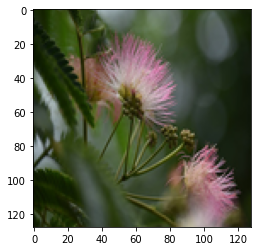

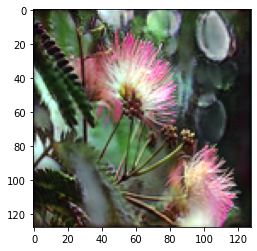

In [247]:
show_image(photos_addr[89])

In [0]:
def test_image(img_addr):
    img = Image.open(img_addr)
    img_np = np.zeros((1, 3, 128, 128), dtype=np.float32)
    temp_np = np.asarray(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(temp_np)
    
    img_np[0] = temp_np.transpose(2, 0, 1)
    
    img_np /= 255
    img_np = img_np * 2 - 1
    img_tensor = torch.from_numpy(img_np)
    img_var = Variable(img_tensor).type(dtype)
    
    photo_var = G_fake_2_real(img_var)
    photo = photo_var.data.cpu().numpy()
    photo = photo[0].transpose(1, 2, 0)
    plt.figure()
    plt.imshow(photo)
    
    paint_var = G_real_2_fake(img_var)
    paint = paint_var.data.cpu().numpy()
    paint = paint[0].transpose(1, 2, 0)
    plt.figure()
    plt.imshow(paint)
    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


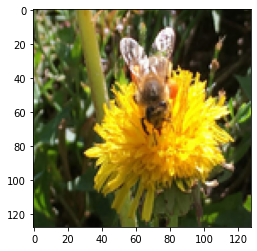

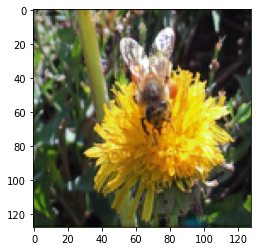

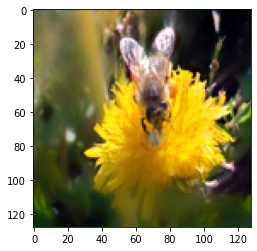

In [314]:
test_image(paintings_addr[115])